<a href="https://colab.research.google.com/github/simasaadi/canada-climate-80yrs/blob/main/05_spatial_patterns_and_climate_extremes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05 — Spatial Patterns of Climate Change & Extremes in Canadian Cities (1940–Present)

This notebook synthesizes long-term climate trends and extreme-event indicators into spatial visualizations.
The focus is on city-level patterns of warming, precipitation change, and temperature extremes across Canada,
using summary statistics derived from daily observations.


In [1]:
# =========================================================
# Notebook 05 — SAFE STARTUP & DATA LINKING (DO NOT EDIT)
# =========================================================

import os
from pathlib import Path
import pandas as pd
import numpy as np

# Always anchor execution
os.chdir("/content")

# Fresh clone to avoid broken state
!rm -rf /content/canada-climate-80yrs
!git clone https://github.com/simasaadi/canada-climate-80yrs.git

REPO_DIR = Path("/content/canada-climate-80yrs")
RAW_DIR = REPO_DIR / "data" / "raw"
PROCESSED_DIR = REPO_DIR / "data" / "processed"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

RAW_PATH = RAW_DIR / "canadian_climate_daily.csv"
TIDY_PATH = PROCESSED_DIR / "climate_daily_tidy.parquet"
MONTHLY_PATH = PROCESSED_DIR / "climate_monthly.parquet"
YEARLY_PATH = PROCESSED_DIR / "climate_yearly.parquet"

print("Repo exists:", REPO_DIR.exists())
print("Raw exists:", RAW_PATH.exists())
print("Processed dir exists:", PROCESSED_DIR.exists())
print("Tidy exists:", TIDY_PATH.exists())
print("Monthly exists:", MONTHLY_PATH.exists())
print("Yearly exists:", YEARLY_PATH.exists())


Cloning into 'canada-climate-80yrs'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 96 (delta 40), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (96/96), 3.23 MiB | 4.84 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Repo exists: True
Raw exists: True
Processed dir exists: True
Tidy exists: False
Monthly exists: False
Yearly exists: False


In [2]:
# Build processed data if missing
if not (TIDY_PATH.exists() and MONTHLY_PATH.exists() and YEARLY_PATH.exists()):
    print("Processed outputs missing — rebuilding now...")

    import re

    df = pd.read_csv(RAW_PATH)
    df["LOCAL_DATE"] = pd.to_datetime(df["LOCAL_DATE"], errors="coerce")
    assert df["LOCAL_DATE"].isna().sum() == 0

    pat = re.compile(r"^(MEAN_TEMPERATURE|TOTAL_PRECIPITATION)_(.+)$")
    value_cols = [c for c in df.columns if pat.match(c)]

    long = df.melt(
        id_vars=["LOCAL_DATE"],
        value_vars=value_cols,
        var_name="series",
        value_name="value",
    )

    long[["metric", "city"]] = long["series"].str.extract(pat)
    long.drop(columns="series", inplace=True)

    tidy = (
        long.pivot_table(
            index=["LOCAL_DATE", "city"],
            columns="metric",
            values="value",
            aggfunc="first",
        )
        .reset_index()
        .rename(columns={
            "LOCAL_DATE": "local_date",
            "MEAN_TEMPERATURE": "mean_temperature",
            "TOTAL_PRECIPITATION": "total_precipitation",
        })
    )

    tidy["city"] = tidy["city"].str.upper().str.strip()
    tidy["year"] = tidy["local_date"].dt.year
    tidy["month"] = tidy["local_date"].dt.month
    tidy["is_freezing"] = tidy["mean_temperature"] < 0

    monthly = tidy.groupby(["city", "year", "month"], as_index=False).agg(
        mean_temperature=("mean_temperature", "mean"),
        total_precipitation=("total_precipitation", "sum"),
    )

    yearly = tidy.groupby(["city", "year"], as_index=False).agg(
        mean_temperature=("mean_temperature", "mean"),
        total_precipitation=("total_precipitation", "sum"),
    )

    tidy.to_parquet(TIDY_PATH, index=False)
    monthly.to_parquet(MONTHLY_PATH, index=False)
    yearly.to_parquet(YEARLY_PATH, index=False)

print("Data ready ✔")


Processed outputs missing — rebuilding now...
Data ready ✔


In [13]:
CITY_COORDS = {
    "CALGARY": (51.0447, -114.0719),
    "EDMONTON": (53.5461, -113.4938),
    "HALIFAX": (44.6488, -63.5752),
    "MONCTON": (46.0878, -64.7782),
    "MONTREAL": (45.5019, -73.5674),
    "OTTAWA": (45.4215, -75.6972),
    "QUEBEC": (46.8139, -71.2080),
    "SASKATOON": (52.1579, -106.6702),
    "STJOHNS": (47.5615, -52.7126),
    "TORONTO": (43.6532, -79.3832),
    "VANCOUVER": (49.2827, -123.1207),
    "WHITEHORSE": (60.7212, -135.0568),
    "WINNIPEG": (49.8951, -97.1384),
}

df_daily["city"] = df_daily["city"].astype(str).str.upper().str.strip()
cities = sorted(df_daily["city"].unique())

missing = [c for c in cities if c not in CITY_COORDS]
print("Cities in data:", cities)
print("Missing coords (must add to CITY_COORDS):", missing)


Cities in data: ['CALGARY', 'EDMONTON', 'HALIFAX', 'MONCTON', 'MONTREAL', 'OTTAWA', 'QUEBEC', 'SASKATOON', 'STJOHNS', 'TORONTO', 'VANCOUVER', 'WHITEHORSE', 'WINNIPEG']
Missing coords (must add to CITY_COORDS): []


In [14]:
df_daily = df_daily.copy()
df_daily["local_date"] = pd.to_datetime(df_daily["local_date"], errors="coerce")
df_daily["year"] = df_daily["local_date"].dt.year
df_daily["month"] = df_daily["local_date"].dt.month

MIN_DAYS_PER_YEAR = 300
BASELINE = (1961, 1990)
RECENT   = (1991, 2020)

# Coverage per city-year
cov = (
    df_daily.groupby(["city", "year"], as_index=False)
    .agg(n_temp=("mean_temperature", "count"),
         n_precip=("total_precipitation", "count"))
)
cov["temp_ok"] = cov["n_temp"] >= MIN_DAYS_PER_YEAR
cov["precip_ok"] = cov["n_precip"] >= MIN_DAYS_PER_YEAR

print("Coverage table:", cov.shape)
cov.head(10)


Coverage table: (998, 6)


,city,year,n_temp,n_precip,temp_ok,precip_ok
0,CALGARY,1940,366,366,True,True
1,CALGARY,1941,365,365,True,True
2,CALGARY,1942,365,365,True,True
3,CALGARY,1943,365,365,True,True
4,CALGARY,1944,366,366,True,True
5,CALGARY,1945,365,365,True,True
6,CALGARY,1946,365,365,True,True
7,CALGARY,1947,365,365,True,True
8,CALGARY,1948,366,366,True,True
9,CALGARY,1949,365,365,True,True


In [15]:
base = df_daily[(df_daily["year"] >= BASELINE[0]) & (df_daily["year"] <= BASELINE[1])].copy()

thresholds = (
    base.groupby("city")["mean_temperature"]
    .quantile([0.05, 0.95])
    .unstack()
    .rename(columns={0.05: "t_p05", 0.95: "t_p95"})
    .reset_index()
)

thresholds["lat"] = thresholds["city"].map(lambda c: CITY_COORDS.get(c, (np.nan, np.nan))[0])
thresholds["lon"] = thresholds["city"].map(lambda c: CITY_COORDS.get(c, (np.nan, np.nan))[1])

thresholds


,city,t_p05,t_p95,lat,lon
0,CALGARY,-18.6,18.60,51.0447,-114.0719
1,EDMONTON,-22.3,18.10,53.5461,-113.4938
2,HALIFAX,-10.3,20.20,44.6488,-63.5752
3,MONCTON,-13.5,20.30,46.0878,-64.7782
4,MONTREAL,-15.0,22.80,45.5019,-73.5674
5,OTTAWA,-15.5,22.80,45.4215,-75.6972
6,QUEBEC,-16.7,20.90,46.8139,-71.2080
7,SASKATOON,-24.5,20.90,52.1579,-106.6702
8,STJOHNS,-8.4,17.92,47.5615,-52.7126
9,TORONTO,-11.1,22.70,43.6532,-79.3832


In [16]:
d = df_daily.merge(thresholds[["city", "t_p05", "t_p95"]], on="city", how="left")

d["is_hot_extreme"]  = d["mean_temperature"] >= d["t_p95"]
d["is_cold_extreme"] = d["mean_temperature"] <= d["t_p05"]

ext_annual = (
    d.groupby(["city", "year"], as_index=False)
    .agg(
        hot_days=("is_hot_extreme", "sum"),
        cold_days=("is_cold_extreme", "sum"),
        n_temp=("mean_temperature", "count"),
        mean_temp=("mean_temperature", "mean"),
        total_precip=("total_precipitation", "sum"),
        wet_days=("total_precipitation", lambda s: int((s > 0).sum())),
        n_precip=("total_precipitation", "count"),
    )
)

ext_annual["temp_ok"] = ext_annual["n_temp"] >= MIN_DAYS_PER_YEAR
ext_annual["precip_ok"] = ext_annual["n_precip"] >= MIN_DAYS_PER_YEAR

ext_annual.head(10)


,city,year,hot_days,cold_days,n_temp,mean_temp,total_precip,wet_days,n_precip,temp_ok,precip_ok
0,CALGARY,1940,15,16,366,3.704098,456.7,119,366,True,True
1,CALGARY,1941,26,12,365,4.907671,392.1,101,365,True,True
2,CALGARY,1942,15,11,365,3.994795,522.5,120,365,True,True
3,CALGARY,1943,17,23,365,4.458082,336.3,89,365,True,True
4,CALGARY,1944,9,3,366,4.964208,432.9,106,366,True,True
5,CALGARY,1945,20,10,365,2.904384,600.8,140,365,True,True
6,CALGARY,1946,16,11,365,4.195068,471.7,129,365,True,True
7,CALGARY,1947,19,14,365,3.740274,504.2,130,365,True,True
8,CALGARY,1948,9,19,366,3.006831,454.5,122,366,True,True
9,CALGARY,1949,15,34,365,3.312603,265.0,105,365,True,True


In [17]:
def period_mean(df, y0, y1, ok_col):
    sub = df[(df["year"] >= y0) & (df["year"] <= y1) & (df[ok_col])]
    return (
        sub.groupby("city", as_index=False)
        .agg(
            hot_days=("hot_days", "mean"),
            cold_days=("cold_days", "mean"),
            mean_temp=("mean_temp", "mean"),
            total_precip=("total_precip", "mean"),
            wet_days=("wet_days", "mean"),
        )
    )

base_m = period_mean(ext_annual, BASELINE[0], BASELINE[1], "temp_ok").rename(columns=lambda c: f"base_{c}" if c!="city" else c)
rec_m  = period_mean(ext_annual, RECENT[0], RECENT[1], "temp_ok").rename(columns=lambda c: f"recent_{c}" if c!="city" else c)

delta = base_m.merge(rec_m, on="city", how="inner")

for metric in ["hot_days", "cold_days", "mean_temp", "total_precip", "wet_days"]:
    delta[f"delta_{metric}"] = delta[f"recent_{metric}"] - delta[f"base_{metric}"]

delta["lat"] = delta["city"].map(lambda c: CITY_COORDS.get(c, (np.nan, np.nan))[0])
delta["lon"] = delta["city"].map(lambda c: CITY_COORDS.get(c, (np.nan, np.nan))[1])

delta.sort_values("delta_mean_temp", ascending=False)


,city,base_hot_days,base_cold_days,base_mean_temp,base_total_precip,base_wet_days,recent_hot_days,recent_cold_days,recent_mean_temp,recent_total_precip,recent_wet_days,delta_hot_days,delta_cold_days,delta_mean_temp,delta_total_precip,delta_wet_days,lat,lon
9,TORONTO,18.366667,18.366667,7.203693,780.900000,141.333333,32.068966,11.034483,8.686749,789.503448,145.551724,13.702299,-7.332184,1.483056,8.603448,4.218391,43.6532,-79.3832
12,WINNIPEG,18.400000,18.933333,2.435402,504.440000,119.400000,22.275862,9.344828,3.833446,533.791379,137.931034,3.875862,-9.588506,1.398044,29.351379,18.531034,49.8951,-97.1384
11,WHITEHORSE,19.166667,18.333333,-1.004347,268.833333,122.200000,26.923077,8.423077,0.294518,201.346154,88.653846,7.756410,-9.910256,1.298865,-67.487179,-33.546154,60.7212,-135.0568
4,MONTREAL,19.166667,18.500000,6.122938,939.703333,162.433333,25.551724,12.413793,7.216552,990.231034,175.206897,6.385057,-6.086207,1.093613,50.527701,12.773563,45.5019,-73.5674
2,HALIFAX,18.466667,18.333333,6.142983,1472.426667,169.933333,26.793103,14.896552,6.945389,1410.917241,163.000000,8.326437,-3.436782,0.802406,-61.509425,-6.933333,44.6488,-63.5752
5,OTTAWA,18.333333,18.300000,5.798486,910.470000,158.566667,21.137931,14.103448,6.597704,925.910345,161.448276,2.804598,-4.196552,0.799218,15.440345,2.881609,45.4215,-75.6972
0,CALGARY,19.233333,18.433333,3.896560,398.573333,110.900000,21.655172,11.586207,4.613458,437.037931,114.000000,2.421839,-6.847126,0.716897,38.464598,3.100000,51.0447,-114.0719
10,VANCOUVER,19.533333,18.466667,9.885413,1167.360000,164.033333,31.793103,13.724138,10.596000,1171.848276,167.931034,12.259770,-4.742529,0.710587,4.488276,3.897701,49.2827,-123.1207
6,QUEBEC,18.666667,18.800000,4.073341,1211.003333,178.500000,20.862069,16.827586,4.751158,1179.943103,185.137931,2.195402,-1.972414,0.677817,-31.060230,6.637931,46.8139,-71.2080
3,MONCTON,19.633333,18.500000,5.029256,1226.776667,170.366667,23.227273,15.090909,5.628795,1165.763636,168.909091,3.593939,-3.409091,0.599539,-61.013030,-1.457576,46.0878,-64.7782


In [18]:
# Cartopy gives real maps with coastlines/borders.
# This usually works in Colab; if it fails, rerun this cell once.

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    CARTOPY_OK = True
except Exception as e:
    CARTOPY_OK = False
    print("Cartopy not available yet:", repr(e))

if not CARTOPY_OK:
    !pip -q install cartopy
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

import matplotlib.pyplot as plt


Cartopy not available yet: ModuleNotFoundError("No module named 'cartopy'")
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 102.0 MB/s eta 0:00:00


In [19]:
def canada_map_base(ax):
    ax.set_extent([-142, -50, 40, 72], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, linewidth=0.0)
    ax.add_feature(cfeature.OCEAN, linewidth=0.0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAKES, alpha=0.4)
    ax.add_feature(cfeature.RIVERS, alpha=0.3)
    gl = ax.gridlines(draw_labels=False, linewidth=0.3, alpha=0.5)
    return ax

def point_map(df, value_col, title, cbar_label):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-95, central_latitude=55))
    canada_map_base(ax)

    sub = df.dropna(subset=["lat", "lon", value_col]).copy()

    sc = ax.scatter(
        sub["lon"], sub["lat"],
        c=sub[value_col],
        s=160,
        transform=ccrs.PlateCarree(),
        edgecolor="black",
        linewidth=0.6,
        alpha=0.9
    )

    for _, r in sub.iterrows():
        ax.text(
            r["lon"] + 0.6, r["lat"] + 0.2,
            r["city"],
            transform=ccrs.PlateCarree(),
            fontsize=8
        )

    cb = plt.colorbar(sc, ax=ax, shrink=0.75, pad=0.02)
    cb.set_label(cbar_label)
    ax.set_title(title)
    plt.show()


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Do

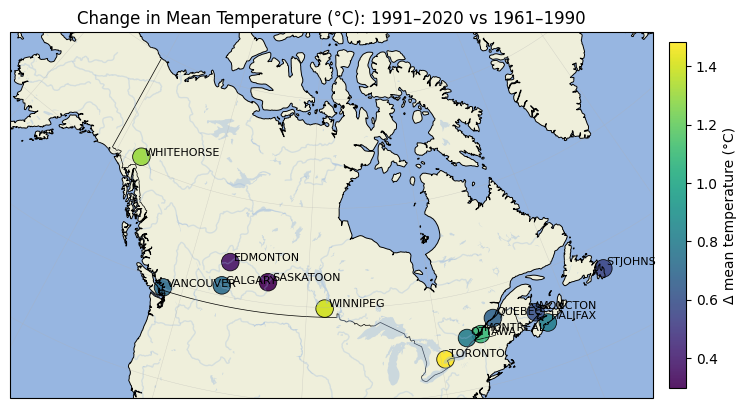

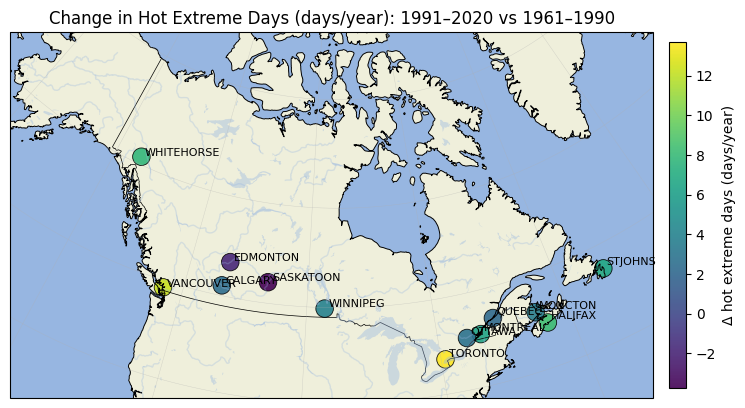

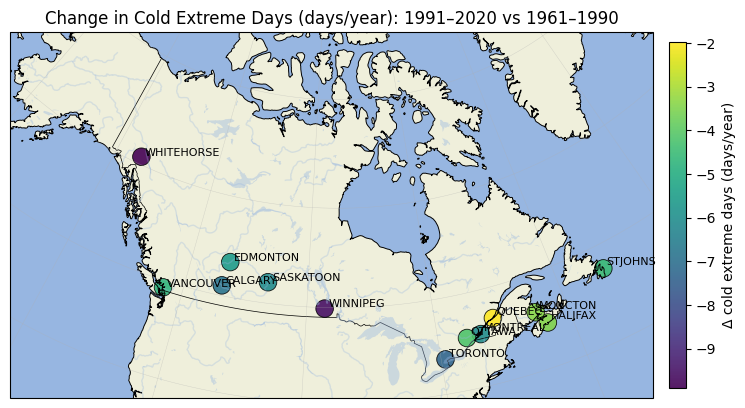

In [20]:
point_map(
    delta,
    "delta_mean_temp",
    f"Change in Mean Temperature (°C): {RECENT[0]}–{RECENT[1]} vs {BASELINE[0]}–{BASELINE[1]}",
    "Δ mean temperature (°C)"
)

point_map(
    delta,
    "delta_hot_days",
    f"Change in Hot Extreme Days (days/year): {RECENT[0]}–{RECENT[1]} vs {BASELINE[0]}–{BASELINE[1]}",
    "Δ hot extreme days (days/year)"
)

point_map(
    delta,
    "delta_cold_days",
    f"Change in Cold Extreme Days (days/year): {RECENT[0]}–{RECENT[1]} vs {BASELINE[0]}–{BASELINE[1]}",
    "Δ cold extreme days (days/year)"
)


In [21]:
def ols_slope_ci(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    n = len(x)
    if n < 15:
        return None

    x0 = x - x.mean()
    b = np.sum(x0 * (y - y.mean())) / np.sum(x0**2)
    a = y.mean() - b * x.mean()

    yhat = a + b * x
    resid = y - yhat
    s2 = np.sum(resid**2) / (n - 2)
    se_b = np.sqrt(s2 / np.sum(x0**2))

    z = 1.96
    lo, hi = b - z * se_b, b + z * se_b

    return {
        "n": n,
        "slope_per_decade": b * 10,
        "ci95_lo_decade": lo * 10,
        "ci95_hi_decade": hi * 10,
    }

trend_rows = []
for c in sorted(ext_annual["city"].unique()):
    tmp = ext_annual[(ext_annual["city"] == c) & (ext_annual["temp_ok"])].sort_values("year")
    res = ols_slope_ci(tmp["year"], tmp["mean_temp"])
    if res:
        trend_rows.append({"city": c, **res})

temp_trends = pd.DataFrame(trend_rows)
temp_trends["lat"] = temp_trends["city"].map(lambda c: CITY_COORDS.get(c, (np.nan, np.nan))[0])
temp_trends["lon"] = temp_trends["city"].map(lambda c: CITY_COORDS.get(c, (np.nan, np.nan))[1])

temp_trends.sort_values("slope_per_decade", ascending=False)


,city,n,slope_per_decade,ci95_lo_decade,ci95_hi_decade,lat,lon
12,WINNIPEG,80,0.278374,0.168847,0.387900,49.8951,-97.1384
9,TORONTO,80,0.222906,0.139200,0.306611,43.6532,-79.3832
0,CALGARY,80,0.218268,0.121441,0.315095,51.0447,-114.0719
2,HALIFAX,60,0.214883,0.113035,0.316731,44.6488,-63.5752
11,WHITEHORSE,74,0.214584,0.100859,0.328310,60.7212,-135.0568
1,EDMONTON,59,0.158745,-0.005551,0.323042,53.5461,-113.4938
5,OTTAWA,80,0.142611,0.072109,0.213112,45.4215,-75.6972
4,MONTREAL,78,0.139617,0.059082,0.220152,45.5019,-73.5674
7,SASKATOON,73,0.133295,0.013912,0.252678,52.1579,-106.6702
10,VANCOUVER,80,0.126076,0.070456,0.181695,49.2827,-123.1207


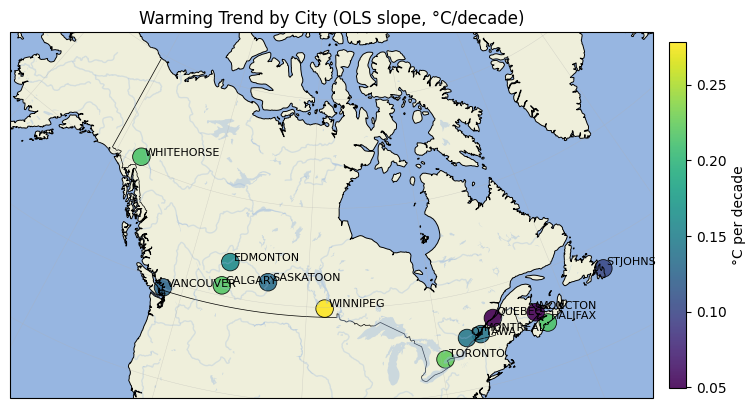

In [22]:
point_map(
    temp_trends,
    "slope_per_decade",
    "Warming Trend by City (OLS slope, °C/decade)",
    "°C per decade"
)


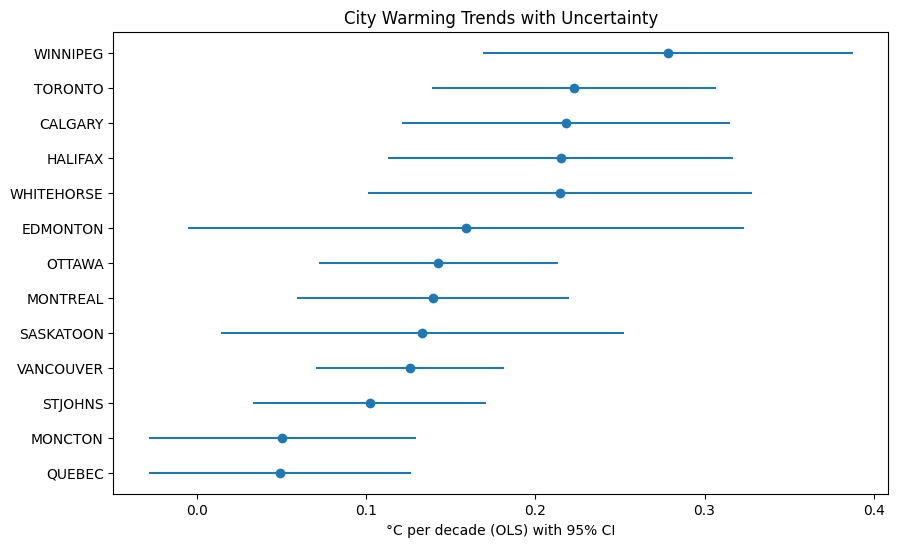

In [23]:
t = temp_trends.dropna(subset=["slope_per_decade"]).sort_values("slope_per_decade", ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(
    t["slope_per_decade"],
    np.arange(len(t)),
    xerr=[
        t["slope_per_decade"] - t["ci95_lo_decade"],
        t["ci95_hi_decade"] - t["slope_per_decade"],
    ],
    fmt="o"
)
ax.set_yticks(np.arange(len(t)))
ax.set_yticklabels(t["city"])
ax.set_xlabel("°C per decade (OLS) with 95% CI")
ax.set_title("City Warming Trends with Uncertainty")
plt.show()


In [24]:
REPORT_DIR = REPO_DIR / "reports" / "spatial"
REPORT_DIR.mkdir(parents=True, exist_ok=True)

delta_out = REPORT_DIR / "period_deltas_baseline_vs_recent.csv"
trends_out = REPORT_DIR / "temp_trends_ols_city.csv"

delta.to_csv(delta_out, index=False)
temp_trends.to_csv(trends_out, index=False)

print("Saved:")
print(" -", delta_out)
print(" -", trends_out)
!ls -lah /content/canada-climate-80yrs/reports/spatial


Saved:
 - /content/canada-climate-80yrs/reports/spatial/period_deltas_baseline_vs_recent.csv
 - /content/canada-climate-80yrs/reports/spatial/temp_trends_ols_city.csv
total 16K
drwxr-xr-x 2 root root 4.0K Dec 12 21:15 .
drwxr-xr-x 3 root root 4.0K Dec 12 21:15 ..
-rw-r--r-- 1 root root 4.0K Dec 12 21:15 period_deltas_baseline_vs_recent.csv
-rw-r--r-- 1 root root 1.2K Dec 12 21:15 temp_trends_ols_city.csv
